In [23]:
import numpy as np
import os
from skimage.io import imread
import cv2 as cv
from pathlib import Path
import json
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

%matplotlib inline

# Functions to load train and test images

In [24]:
def load_train_data(input_dir, newSize=(64,64)):
    image_dir = Path(input_dir)
    categories_name = []

    for file in os.listdir(image_dir):
        d = os.path.join(image_dir, file)
        if os.path.isdir(d):
            categories_name.append(file)

    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]

    train_img = []
    categories_count=[]
    labels=[]

    for _, direc in enumerate(folders):
        count = 0
        for obj in direc.iterdir():
            if os.path.isfile(obj) and os.path.basename(os.path.normpath(obj)) != 'desktop.ini':
                labels.append(os.path.basename(os.path.normpath(direc)))
                count += 1
                img = imread(obj) #zwraca ndarry postaci xSize x ySize x colorDepth
                img = cv.resize(img, newSize, interpolation=cv.INTER_AREA) # zwraca ndarray
                img = img / 255 #normalizacja
                train_img.append(img)
        categories_count.append(count)

    X={}
    X["values"] = np.array(train_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X


In [25]:
data = load_train_data('./train_test_sw/train_sw')
print(data['categories_name'])
print(data['categories_count'])
print([data["labels"][50],data["labels"][200],data["labels"][300]])
print(list(data["values"][100][1][10]))

KeyboardInterrupt: 

In [ ]:
def load_test_data(input_dir, newSize=(64,64)):
    image_path = Path(input_dir)
    labels_path = image_path.parents[0] / 'test_labels.json'

    jsonString = labels_path.read_text()
    objects = json.loads(jsonString)

    categories_name = []
    categories_count=[]
    count = 0
    c = objects[0]['value']

    for e in  objects:
        if e['value'] != c:
            categories_count.append(count)
            c = e['value']
            count = 1
        else:
            count += 1
        if not e['value'] in categories_name:
            categories_name.append(e['value'])

    categories_count.append(count)

    test_img = []
    labels=[]

    for e in objects:
        p = image_path / e['filename']
        img = imread(p)
        img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)
        img = img / 255
        test_img.append(img)
        labels.append(e['value'])

    X={}
    X["values"] = np.array(test_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X


In [ ]:
data = load_test_data('./train_test_sw/test_sw')
print(data['categories_name'])
print(data['categories_count'])
print([data["labels"][10],data["labels"][20],data["labels"][30]])
print(list(data["values"][10][1][10]))

['Beech', 'Gardenia', 'Lemon', 'Mean', 'Tomato']
[51, 52, 52, 52, 52]
['Beech', 'Beech', 'Beech']
[0.058823529411764705, 0.00784313725490196, 0.0, 1.0]


# Make a train and test sets, plus encode labels

In [ ]:
data_train = load_train_data("./train_test_sw/train_sw",newSize=(64,64))
X_train = data_train['values']
y_train = data_train['labels']

data_test = load_test_data("./train_test_sw/test_sw",newSize=(64,64))
X_test = data_test['values']
y_test = data_test['labels']

class_le = LabelEncoder()

y_train_enc = class_le.fit_transform(y_train)
y_test_enc = class_le.fit_transform(y_test)

# Display 10 random images from training set

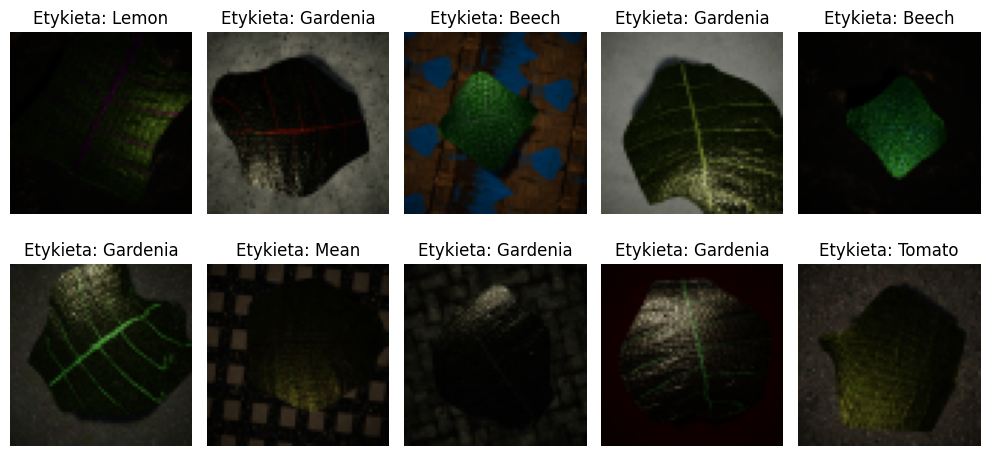

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()
values = np.random.randint(1, 1000, 10)

for i, j in enumerate(values):
    axes[i].imshow(X_train[j], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Etykieta: {y_train[j]}")

plt.tight_layout()

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def sigmoid_derivative(x):
    return x * (1 - x)

def relu_derivative(x):
    x[x <= 0] = 0
    x[x > 0] = 1
    return x

def softmax(x):
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps, axis=0)

# Neural Network

In [26]:
class NN:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.w1 = np.random.randn(self.input_size, self.hidden_size)
        self.w2 = np.random.randn(self.hidden_size, self.output_size)
        self.b1 = np.zeros((1, self.hidden_size))
        self.b2 = np.zeros((1, self.output_size))

    def __str__(self) -> str:
        return f"Układ Sieci Neuronowej:\n \
                Warstwa Wejściowa: {self.input_size} neuronów\n \
                Warstwa Ukryta: {self.hidden_size} neuronów\n \
                Warstwa Wyjściowa: {self.output_size} neuronów\n"

    def __call__(self, X, activation_function=sigmoid):
        z1 = (X @ self.w1) + self.b1
        self.a1 = activation_function(z1)
        z2 = self.a1 @ self.w2 + self.b2
        self.a2 = softmax(z2)
        return self.a2

    def backward(self, X, y, learning_rate):
        m = X.shape[0]

        dz2 = self.a2 - y
        dw2 = (self.a1.T @ dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        dz1 = dz2 @ self.w2.T * sigmoid_derivative(self.a1)
        dw1 = (X.T @ dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        self.w1 -= learning_rate * dw1
        self.b1 -= learning_rate * db1
        self.w2 -= learning_rate * dw2
        self.b2 -= learning_rate * db2

In [ ]:
def cross_entropy(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred))

In [28]:
input_shape = 16384
hidden_shape = 1024
output_shape = len(np.unique(y_train_enc))

print(f"input: {input_shape}, hidden: {hidden_shape}, output: {output_shape}")

model = NN(input_shape, hidden_shape, output_shape)
X_train_enc = X_train.reshape(X_train.shape[0], -1)

print(X_train_enc.shape)
epochs = 1000
learning_rate = 0.01

for epoch in range(epochs):
    y_pred = model(X_train_enc) # 1027, 64, 64, 4
    loss = cross_entropy(np.eye(output_shape)[y_train_enc], y_pred)
    model.backward(X_train_enc, np.eye(output_shape)[y_train_enc], learning_rate)

    if epoch % 100 == 0:
        print(f"Epoka: {epoch}, Strata: {loss/16384}")
    

input: 16384, hidden: 1024, output: 5
(1027, 16384)
Epoka: 0, Strata: 1.229692974842017
Epoka: 100, Strata: 0.7069610753023884
Epoka: 200, Strata: 0.6564889280853335


KeyboardInterrupt: 